In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])


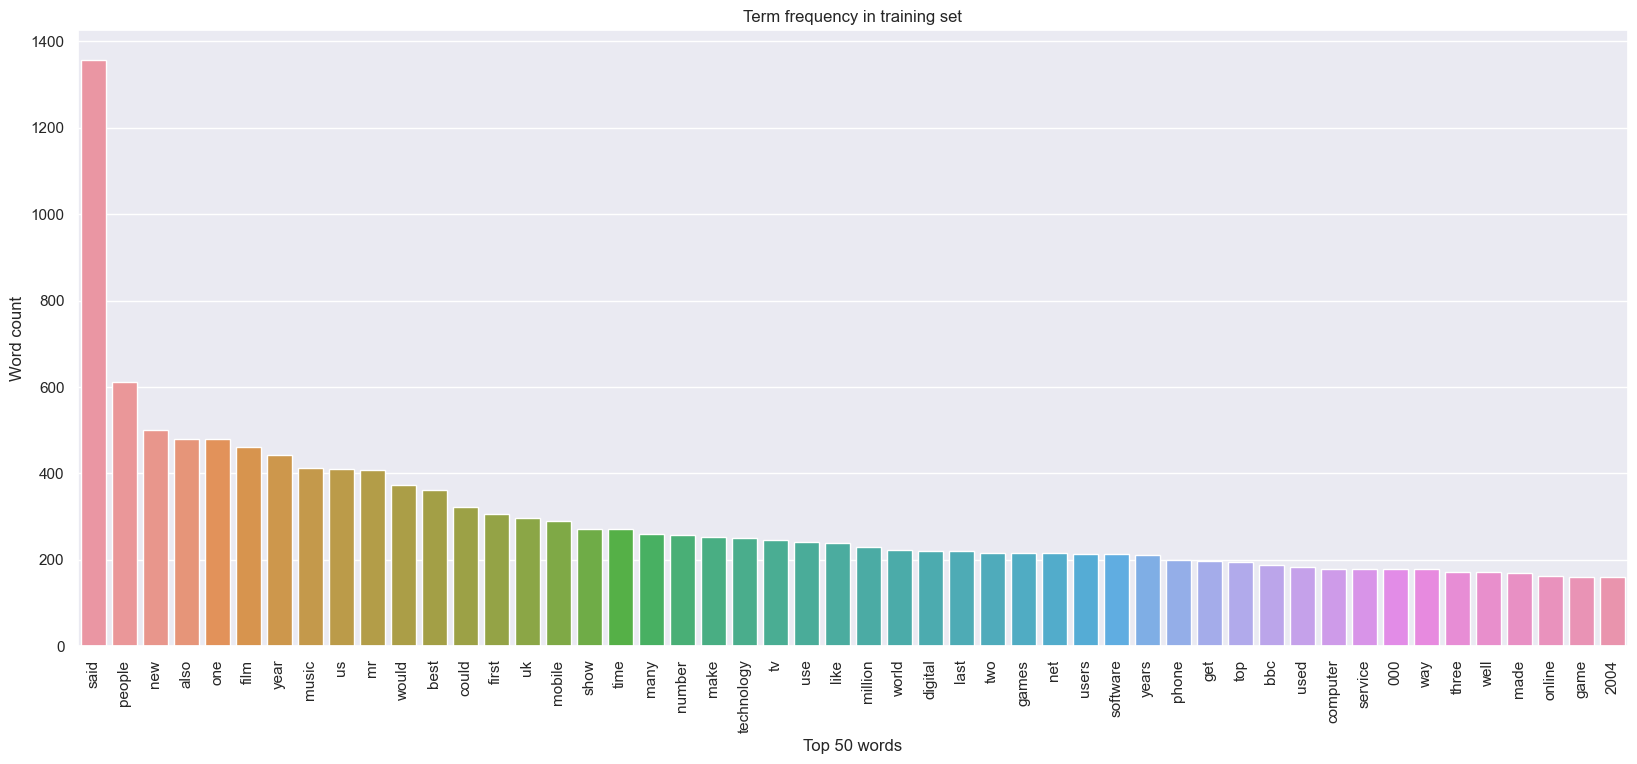

In [3]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

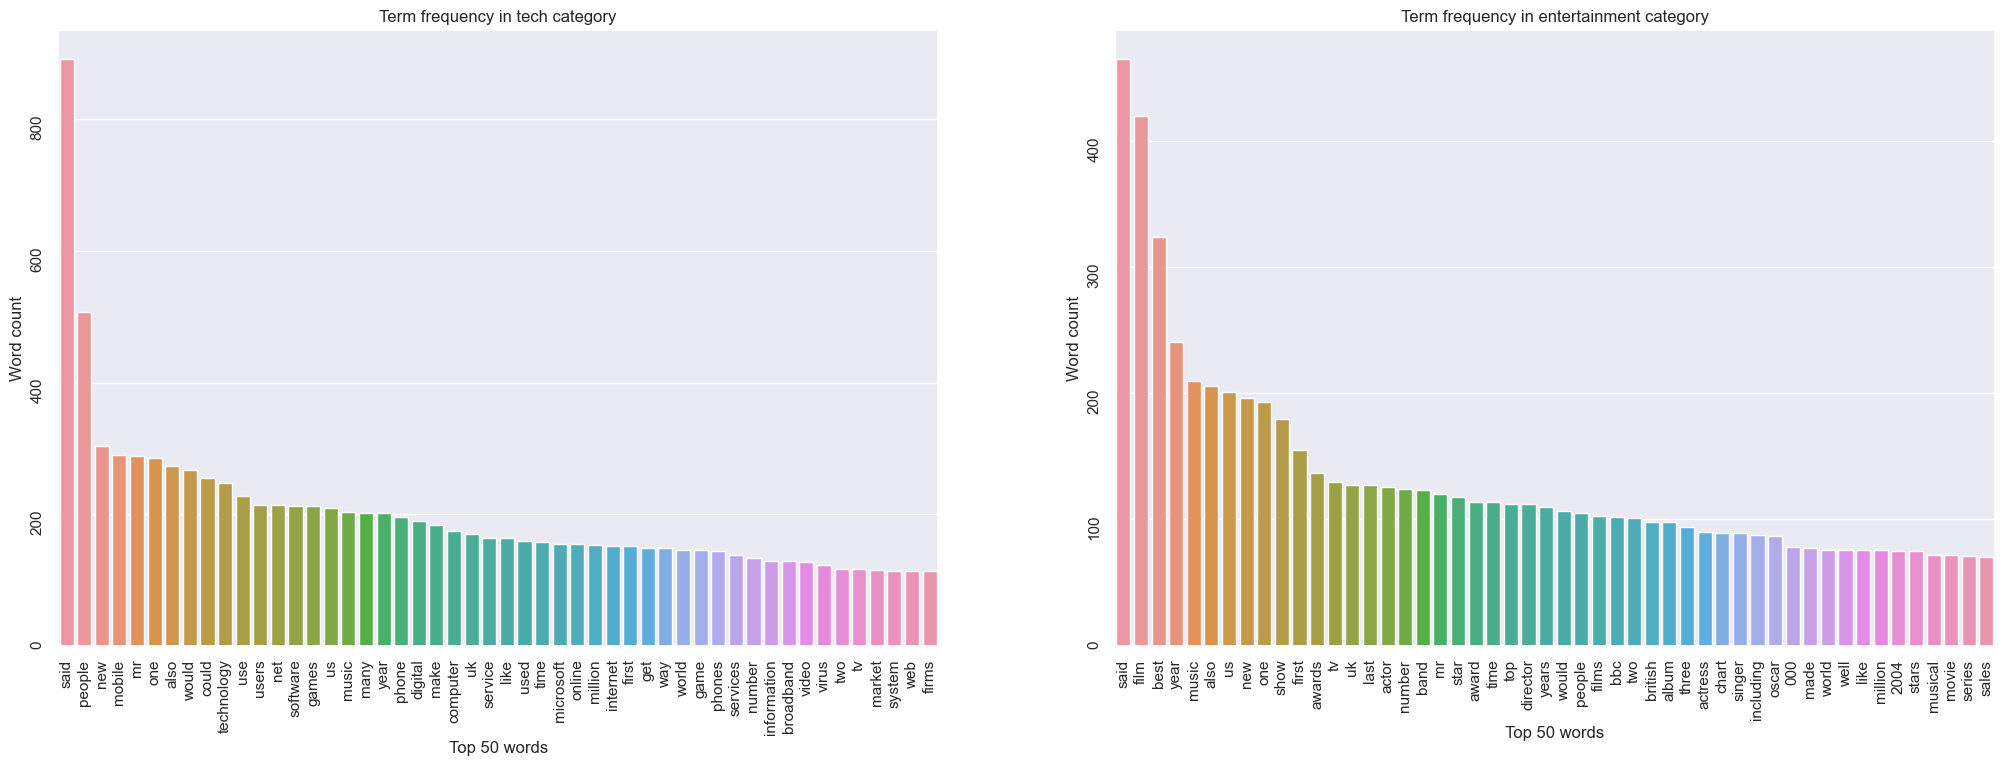

In [4]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

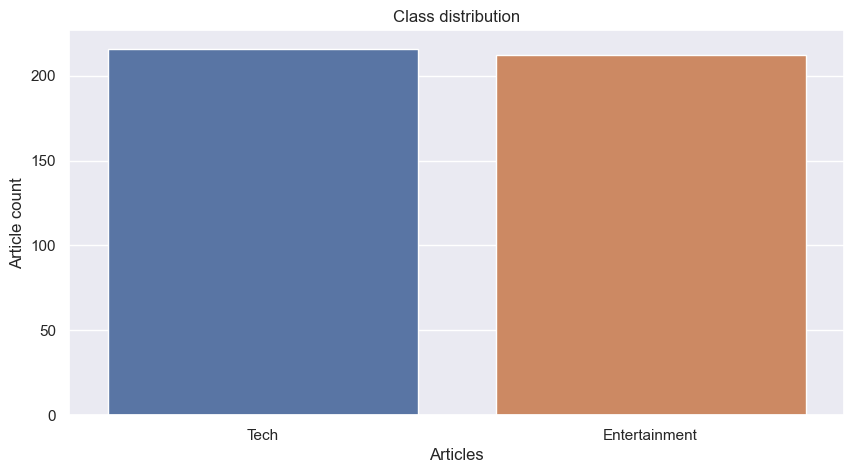

In [5]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [10]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [61]:
from sklearn.neural_network import MLPClassifier
import warnings

weight_init_range = [0,0.1]

# New MLP class to override init method to initialize weights
class MLPClassifierOverride(MLPClassifier):
    # Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out, dtype):
        # Initialize weights and biases by uniformly sampling from range [0, 0.1]
        coef_init = np.random.uniform(
            weight_init_range[0], weight_init_range[1], (fan_in, fan_out)
        )
        intercept_init = np.random.uniform(weight_init_range[0], weight_init_range[1], fan_out)
        coef_init = coef_init.astype(dtype, copy=False)
        intercept_init = intercept_init.astype(dtype, copy=False)
        return coef_init, intercept_init

In [62]:
warnings.filterwarnings('ignore')

np.random.seed(1)

hid_units = [5,20,40]
results = []
training_losses = []

for hid_unit in hid_units:
    clf = MLPClassifierOverride(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    training_losses.append(clf.loss_curve_)

    results.append([hid_unit, score])

training_losses = np.array(training_losses)
print(results)

[[5, 0.5849056603773585], [20, 0.7075471698113207], [40, 0.7547169811320755]]


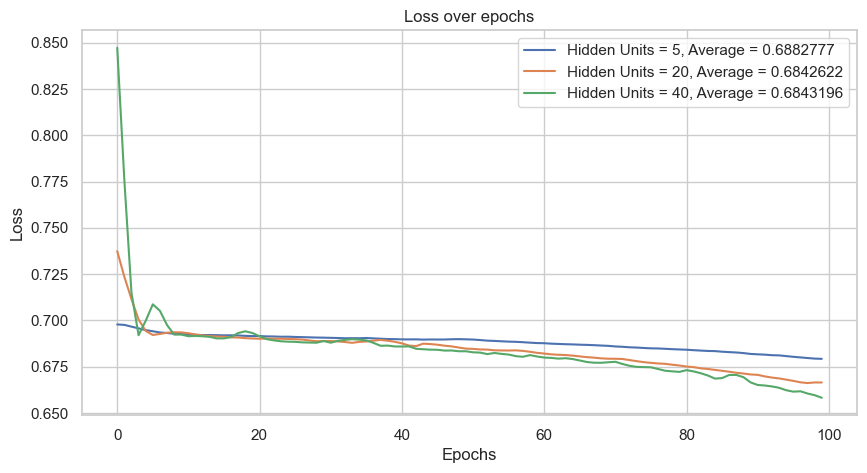

In [64]:
epochs = np.arange(100)
average_losses = np.mean(training_losses, axis=1)
average_losses = np.round(average_losses, decimals= 7)

plot = sns.lineplot(x = epochs, y = training_losses[0], label = str('Hidden Units = 5, Average = ' + str(average_losses[0])))
sns.lineplot(x = epochs, y = training_losses[1], label = str('Hidden Units = 20, Average = ' + str(average_losses[1])))
sns.lineplot(x = epochs, y = training_losses[2], label = str('Hidden Units = 40, Average = ' + str(average_losses[2])))
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.legend()
plt.show()

# SVM

1.0
0.9716981132075472


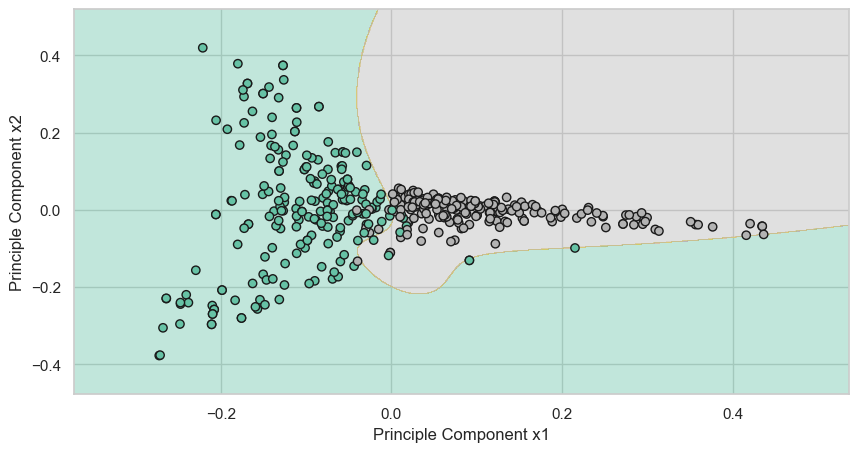

In [ ]:
from sklearn import svm


np.random.seed(34)


# Using non-PCA data.
rbf_svc = svm.SVC(kernel='rbf', C=10000000, gamma=2)
rbf_svc.fit(prep_X_train,Y_train)

preds = rbf_svc.predict(prep_X_test)
score = rbf_svc.score(prep_X_test, Y_test)
print(score)




# Using PCA data to train and plot decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])

rbf_svc.fit(pca_X_train,Y_train)

preds = rbf_svc.predict(pca_X_test)
score = rbf_svc.score(pca_X_test, Y_test)
print(score)



# Print PCA decision boundaries.

disp = DecisionBoundaryDisplay.from_estimator(rbf_svc, pca_X_train, response_method="predict", 
                                              alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                              xlabel="Principle Component x1", ylabel="Principle Component x2")
disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
plt.show()




0.9905660377358491
0.9811320754716981


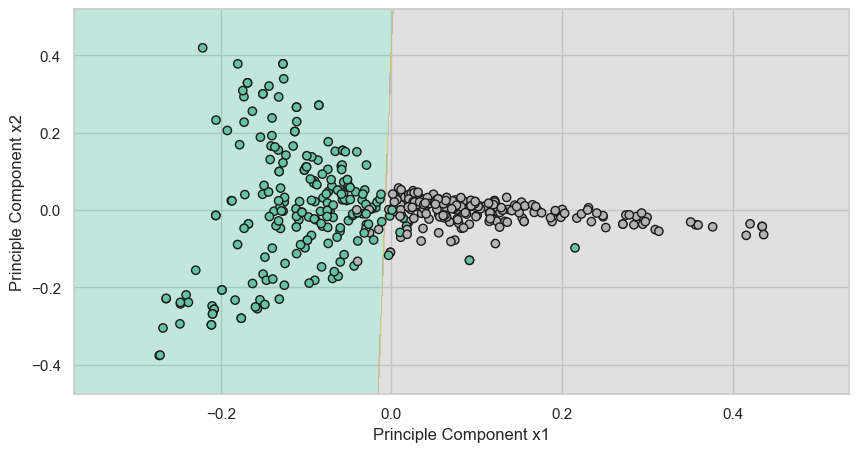

In [ ]:
# Using non-PCA data.
lin_svc = svm.LinearSVC(C=0.7)
lin_svc.fit(prep_X_train,Y_train)

preds = lin_svc.predict(prep_X_test)
score = lin_svc.score(prep_X_test, Y_test)
print(score)




# Using PCA data to train and plot decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])

lin_svc.fit(pca_X_train,Y_train)

preds = lin_svc.predict(pca_X_test)
score = lin_svc.score(pca_X_test, Y_test)
print(score)



# Print PCA decision boundaries.
disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", 
                                              alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                              xlabel="Principle Component x1", ylabel="Principle Component x2")
disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
plt.show()
